# This notebook will use pyTorch to classify the componentX 
We will use pyTorch and the Transformer architecture to do classifications of the life time for Component X.

In [1]:
#Includes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm.notebook import tqdm

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
#Read the raw data
#Train data
tteTrain = pd.read_csv('../data/train_tte.csv')
specificationsTrain = pd.read_csv('../data/train_specifications.csv')
readoutsTrain = pd.read_csv('../data/train_operational_readouts.csv')


#Validation data
labelsValidation = pd.read_csv('../data/validation_labels.csv')
specificationsValidation = pd.read_csv('../data/validation_specifications.csv')
readoutsValidation = pd.read_csv('../data/validation_operational_readouts.csv')

#Test data
specificationsTest = pd.read_csv('../data/test_specifications.csv')
readoutsTest = pd.read_csv('../data/test_operational_readouts.csv')
#No labels for test data yet


In [3]:
#First we group by vehicle_id and we will forward fill the last known value.
#Then if the entire column is NaN, we will fill it with the median of the column. 
#If there are still any NaNs we will fill them with 0.

def fill_missing_values(df):
    df = df.groupby('vehicle_id').apply(lambda x: x.ffill(axis=0)) #Forward fill last known value, but only for the same vehicle
    df = df.droplevel('vehicle_id') #Remove multi-index, as we don't want to group by vehicle_id anymore    
    df = df.fillna(df.median()) #Fill with median rather than mean to avoid outliers
    df = df.fillna(0) #Last resort fill with 0
    
    return df

In [4]:
# #df is the dataframe containing categorical values
# #possible_categories is a dictionary with the column name as the key and the possible categories as the values
# def one_hot_encoding_fixed_columns(df, possible_categories):
    
#     #Create all possible combinations of the columns and categories
#     source_columns = list(possible_categories.keys())
#     cols = [f'{col}_{cat}' for col in source_columns for cat in possible_categories[col]]
    
#     #Create a dataframe with the fixed columns with zeros, using the index of df as the index
#     one_hot_encoded = pd.DataFrame(0, index=df.index, columns=cols, dtype=np.float32) 
    
#     # Get dummies dataset
#     dummies_df = pd.get_dummies(df,columns=source_columns, dtype=np.float32)

#     # Make sure columns exists in both dataframes    
#     cols_in_both = dummies_df.columns.intersection(cols)

#     #Copy the one hot encoded columns to the fixed columns
#     one_hot_encoded[cols_in_both] = dummies_df[cols_in_both]

    
#     return one_hot_encoded

In [5]:
def handle_specifications(specificationsdf):
    #Possible categories for the specifications
    possible_categories = {
        'Spec_0': ['Cat0', 'Cat1', 'Cat2'],
        'Spec_1': ['Cat0', 'Cat1', 'Cat2', 'Cat3', 'Cat4', 'Cat5', 'Cat6', 'Cat7', 'Cat8', 'Cat9', 'Cat10', 'Cat11', 'Cat12', 'Cat13', 'Cat14', 'Cat15', 'Cat16', 'Cat17', 'Cat18', 'Cat19',  'Cat20', 'Cat21', 'Cat22', 'Cat23', 'Cat24', 'Cat25', 'Cat26', 'Cat27', 'Cat28'],
        'Spec_2': ['Cat0', 'Cat1', 'Cat2', 'Cat3', 'Cat4', 'Cat5', 'Cat6', 'Cat7', 'Cat8', 'Cat9', 'Cat10', 'Cat11', 'Cat12', 'Cat13', 'Cat14', 'Cat15', 'Cat16', 'Cat17', 'Cat18', 'Cat19', 'Cat20'],
        'Spec_3': ['Cat0', 'Cat1', 'Cat2', 'Cat3'],
        'Spec_4': ['Cat0', 'Cat1'],
        'Spec_5': ['Cat0', 'Cat1', 'Cat2', 'Cat3', 'Cat4'],
        'Spec_6': ['Cat0', 'Cat1','Cat2', 'Cat3', 'Cat4', 'Cat5', 'Cat6', 'Cat7', 'Cat8', 'Cat9', 'Cat10', 'Cat11', 'Cat12', 'Cat13', 'Cat15', 'Cat17', 'Cat18' ],
        'Spec_7': ['Cat0', 'Cat1', 'Cat2', 'Cat3', 'Cat4', 'Cat5', 'Cat6', 'Cat7', 'Cat8']
    }


    #Create a conversion table for the categories, so that Cat0 is 0, Cat1 is 1, etc.
    conversion_table = {}
    for key in possible_categories.keys():
        conversion_table[key] = {possible_categories[key][i]: i for i in range(len(possible_categories[key]))}

    df = specificationsdf.copy()
    
    for key in conversion_table.keys():
        df[key] = df[key].map(conversion_table[key])

    #Num categories per feature:
    num_categories_per_spec = [len(possible_categories[key]) for key in possible_categories.keys()]


    return df, num_categories_per_spec


    

In [6]:
def add_features(readoutsdf, specificationsdf):
    df = readoutsdf.copy()

    #Convert specifications to integer-based categories
    specificationsdf, num_categories_per_spec = handle_specifications(specificationsdf)

    # Join the specifications for the vehicles, 
    df = pd.merge(df, specificationsdf, on = 'vehicle_id', how='left')

    return df, num_categories_per_spec

In [7]:
df = readoutsTrain.copy()
df = fill_missing_values(df) 
  
#Add features
df, num_categories_per_spec = add_features(df, specificationsTrain)

In [8]:
df.tail()

,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,...,397_34,397_35,Spec_0,Spec_1,Spec_2,Spec_3,Spec_4,Spec_5,Spec_6,Spec_7
1122447,33643,101.0,2136810.0,41412.0,81068654.0,10365.0,843.0,6408272.0,10964376.0,6092347.0,...,17033.0,24.0,0,0,2,0,0,0,1,4
1122448,33643,107.0,2283285.0,44660.0,86639835.0,12317.0,843.0,6596477.0,12358026.0,6721702.0,...,18901.0,24.0,0,0,2,0,0,0,1,4
1122449,33643,113.8,2462865.0,48370.0,93439419.0,13910.0,843.0,6669542.0,12830421.0,7415497.0,...,21237.0,28.0,0,0,2,0,0,0,1,4
1122450,33643,119.8,2627250.0,51101.0,99682931.0,14854.0,843.0,7074468.0,13604706.0,7747492.0,...,22357.0,32.0,0,0,2,0,0,0,1,4
1122451,33643,125.8,2741460.0,52949.0,104122894.0,15222.0,843.0,7988418.0,16274631.0,8095988.0,...,23453.0,32.0,0,0,2,0,0,0,1,4


In [9]:
# We want to create labels for the training data based on the time to event data
# Labels in validation set are denoted by 0, 1, 2, 3, 4 where they are related to readouts within a time window of: (more than 48), (48 to 24), (24 to 12), (12 to 6), and (6 to 0) time_step before the failure, respectively. 
# If we don't have a failure reported, and the time_step left is less 48 we don't know when the failure will happen, so we will label it as -1. 

def get_class_label_train(row):
    #classes denoted by 0, 1, 2, 3, 4 where they are related to readouts within a time window of: (more than 48), (48 to 24), (24 to 12), (12 to 6), and (6 to 0) time_step before the failure, respectively
    if row['time_to_potential_event'] > 48:
        return 0 #No failure within 48 time steps
    elif row['time_to_potential_event'] > 24 and row['in_study_repair'] == 1:
        return 1 #Failure within 48 to 24 time steps
    elif row['time_to_potential_event'] > 12 and row['in_study_repair'] == 1:
        return 2 #Failure within 24 to 12 time steps
    elif row['time_to_potential_event'] > 6 and row['in_study_repair'] == 1:
        return 3 #Failure within 12 to 6 time steps
    elif row['time_to_potential_event'] > 0 and row['in_study_repair'] == 1:
        return 4 #Failure within 6 to 0 time steps
    else:
        return -1 #No failure reported, but within 48 time steps from the end of the study, don't know if it will fail or not
    
def add_class_labels_train(ttedf, readoutsdf):
    # Join the readouts and the time to event data
    df = pd.merge(readoutsdf, ttedf, on = 'vehicle_id', how='left').copy()

    #Calculate the time to a failure event
    df['time_to_potential_event'] = df['length_of_study_time_step'] - df['time_step']

    df['class_label'] = df.apply(get_class_label_train, axis=1)

    return df

In [10]:
# We want to create labels for the training data based on the time to event data
# Labels in validation set are denoted by 0, 1, 2, 3, 4 where they are related to readouts within a time window of: (more than 48), (48 to 24), (24 to 12), (12 to 6), and (6 to 0) time_step before the failure, respectively. 
# The validation_labels.csv file has 5046 rows, which is equal to the number of vehicles contributed to the operational data of the
# validation set. It includes a column named class_label, corresponding to the class for the last readout of each vehicle.
# As mentioned in subsection validation_operational_readouts.csv, the last readout for the validation set is selected randomly
# among all readouts for each vehicle. The temporal placement of this final simulated readout is categorized into five classes
# denoted by 0, 1, 2, 3, 4 where they are related to readouts within a time window of: (more than 48), (48 to 24), (24 to 12), (12
# to 6), and (6 to 0) time_step before the failure, respectively. These classes show the time windows in which the last readouts for
# each vehicle are randomly selected.

def get_class_label_validation(row):
    #classes denoted by 0, 1, 2, 3, 4 where they are related to readouts within a time window of: (more than 48), (48 to 24), (24 to 12), (12 to 6), and (6 to 0) time_step before the failure, respectively
    dt = row['time_to_potential_event'] #Time left to the end of the time series

    #Add time based on the class_labels
    if row['class_label'] == 0:
        #(48+) after last readout
        dt += 48
    elif row['class_label'] == 1:
        #(48 to 24) after last readout
        dt += 24
    elif row['class_label'] == 2:
        #(24 to 12) after last readout
        dt += 12
    elif row['class_label'] == 3:
        #(12 to 6) after last readout
        dt += 6
    elif row['class_label'] == 4:
        #(6 to 0) after last readout
        dt += 0


    if dt >= 48:
        return 0 #No failure within 48 time steps
    elif dt >= 24:
        return 1 #Failure within 48 to 24 time steps
    elif dt >= 12:
        return 2 #Failure within 24 to 12 time steps
    elif dt >= 6:
        return 3 #Failure within 12 to 6 time steps
    elif dt >= 0:
        return 4 #Failure within 6 to 0 time steps
    else:
        return -1 #Should not happen...
    
def add_class_labels_validation(ttedf, readoutsdf):
    # Join the readouts and the time to event data
    df = pd.merge(readoutsdf, ttedf, on = 'vehicle_id', how='left').copy()

    # For each vehicle get the max time_step seen for that vehicle:
    df['length_of_study_time_step'] = df.groupby('vehicle_id')['time_step'].transform('max')

    #Calculate the time to a failure event
    df['time_to_potential_event'] = df['length_of_study_time_step'] - df['time_step']

    df['class_label'] = df.apply(get_class_label_validation, axis=1)

    return df

In [11]:
#This function will preprocess all the data step by step and return X and y
def preprocess_all(readoutsdf, specificationsdf, ttedf=None, validation=False):
    #Fill missing values
    df = fill_missing_values(readoutsdf) 
  
    #Add features

    df, num_categories_per_spec = add_features(df, specificationsdf)

    #We only have information about the class labels in the training and validation data
    if ttedf is not None:

        #Merge the time to event data with the readouts data and figure out which class they belong to
        #Later we will need to remove the columns: length_of_study_time_step, in_study_repair, time_to_potential_event, class_label and remove any rows with class label -1

        #Train and validation targets are structured in different ways, needs to be handled differently
        if validation:
            df = add_class_labels_validation(ttedf, df)
            #Drop the columns that we cannot use for training, since they contain information about the class label
            df = df.drop(columns = ['length_of_study_time_step', 'time_to_potential_event'])
        else:
            df = add_class_labels_train(ttedf, df)
            #Drop the columns that we cannot use for training, since they contain information about the class label
            df = df.drop(columns = ['length_of_study_time_step', 'in_study_repair', 'time_to_potential_event'])

        # Remove classes with class -1, where we don't know if the vehicle will fail or not within 48 hours
        df = df[df['class_label'] != -1]

    # categoryColumns = [col for col in specificationsdf.columns if 'Spec' in col]
    
    # dfCategories = df[categoryColumns] #Take only the columns that are categories
    # df = df.drop(columns = categoryColumns) #Drop the columns that are categories
  
    return df, num_categories_per_spec

In [12]:
labelsValidation.head()

,vehicle_id,class_label
0,10,0
1,16,0
2,18,0
3,23,0
4,45,0


In [13]:

dfTrain, num_categories_per_spec = preprocess_all(readoutsTrain, specificationsTrain, tteTrain, validation=False)
dfValidation, _ = preprocess_all(readoutsValidation, specificationsValidation, labelsValidation, validation=True)
dfTest, _ = preprocess_all(readoutsTest, specificationsTest)
#dfTrain, XTrain, yTrain = preprocess_all(readoutsTrain, specificationsTrain, tteTrain, validation=False)
# XValidation, yValidation = preprocess_all(readoutsValidation, specificationsValidation, labelsValidation, validation=True)
# XTest, yTest = preprocess_all(readoutsTest, specificationsTest)

In [14]:
dfTrain.head()

,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,...,397_35,Spec_0,Spec_1,Spec_2,Spec_3,Spec_4,Spec_5,Spec_6,Spec_7,class_label
0,0,11.2,167985.0,10787.0,7413813.0,2296.0,4110.0,1296420.0,1628265.0,630345.0,...,452.0,0,0,0,0,0,0,0,0,0
1,0,11.4,167985.0,10787.0,7413813.0,2296.0,4111.0,1302855.0,1628265.0,630345.0,...,452.0,0,0,0,0,0,0,0,0,0
2,0,19.6,331635.0,14525.0,13683604.0,2600.0,4111.0,1302855.0,1628265.0,630345.0,...,452.0,0,0,0,0,0,0,0,0,0
3,0,20.2,354975.0,15015.0,14540449.0,2616.0,4111.0,1302855.0,1628265.0,630345.0,...,453.0,0,0,0,0,0,0,0,0,0
4,0,21.0,365550.0,15295.0,14966985.0,2720.0,4111.0,1302855.0,1628265.0,630345.0,...,454.0,0,0,0,0,0,0,0,0,0


In [15]:
# Use Scikit-learn to normalize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
#Normalize the data, but only the columns that are not one hot encoded
colsToIgnore = ['vehicle_id', 'class_label', 'Spec']
#Get the columns that we don't ignore
columns = [col for col in dfTrain.columns if all(ignored not in col for ignored in colsToIgnore)]

#Fit and transform the data
dfTrain[columns] = scaler.fit_transform(dfTrain[columns])

#Use the same transformation for the validation and test data
dfValidation[columns] = scaler.transform(dfValidation[columns])
dfTest[columns] = scaler.transform(dfTest[columns])

In [16]:
dfTrain.describe()

,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,...,397_35,Spec_0,Spec_1,Spec_2,Spec_3,Spec_4,Spec_5,Spec_6,Spec_7,class_label
count,919315.000000,9.193150e+05,9.193150e+05,9.193150e+05,9.193150e+05,9.193150e+05,9.193150e+05,9.193150e+05,9.193150e+05,9.193150e+05,...,9.193150e+05,919315.000000,919315.000000,919315.000000,919315.000000,919315.000000,919315.000000,919315.000000,919315.000000,919315.000000
mean,15206.614850,1.310846e-16,-5.441248e-17,-2.671158e-17,-6.381100e-17,-3.462612e-18,3.920172e-17,3.227649e-17,-5.564913e-17,-3.932538e-17,...,-2.012643e-17,0.190648,3.816901,1.747000,0.610904,0.016777,0.307290,1.157302,1.944170,0.054272
std,9774.004888,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,0.395990,5.026650,2.514605,0.916742,0.128434,0.713147,1.560122,2.253661,0.368800
min,0.000000,-1.436019e+00,-1.193171e+00,-8.203732e-01,-1.237974e+00,-5.394333e-01,-2.757221e-01,-1.178886e+00,-1.079403e+00,-9.028752e-01,...,-2.262132e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6247.000000,-7.990563e-01,-7.675430e-01,-6.320502e-01,-7.657070e-01,-5.071259e-01,-2.713850e-01,-7.250011e-01,-6.907598e-01,-6.031002e-01,...,-2.208853e-01,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15468.000000,-1.942870e-01,-2.552939e-01,-3.233495e-01,-2.380003e-01,-3.538917e-01,-1.978337e-01,-2.556182e-01,-2.655115e-01,-2.584784e-01,...,-1.998810e-01,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,22990.000000,6.657271e-01,5.343218e-01,2.641196e-01,5.427373e-01,8.945324e-02,1.825215e-02,4.378583e-01,3.908949e-01,2.778524e-01,...,-1.063348e-01,0.000000,5.000000,2.000000,1.000000,0.000000,0.000000,1.000000,4.000000,0.000000
max,33643.000000,4.073591e+00,9.292816e+00,4.314025e+01,8.652973e+00,8.920041e+01,1.928817e+02,1.142972e+01,1.960565e+01,2.972276e+01,...,5.991361e+01,2.000000,28.000000,20.000000,3.000000,1.000000,4.000000,16.000000,8.000000,4.000000


In [17]:
dfValidation.head()

,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,...,397_35,Spec_0,Spec_1,Spec_2,Spec_3,Spec_4,Spec_5,Spec_6,Spec_7,class_label
0,10,-1.401526,-1.174908,-0.792514,-1.215986,-0.519401,-0.275722,-1.123193,-1.054025,-0.895208,...,-0.226213,0,0,0,0,0,1,0,1,0
1,10,-1.350937,-1.143335,-0.694372,-1.167848,-0.475053,-0.275722,-1.049603,-1.033836,-0.880753,...,-0.123241,0,0,0,0,0,1,0,1,0
2,10,-1.344038,-1.136706,-0.672664,-1.158933,-0.467178,-0.275722,-1.045711,-1.029650,-0.879821,...,-0.072523,0,0,0,0,0,1,0,1,0
3,10,-1.298048,-1.119632,-0.637477,-1.137810,-0.436923,-0.207791,-1.009742,-1.020041,-0.875221,...,-0.063199,0,0,0,0,0,1,0,1,0
4,10,-1.295749,-1.119626,-0.637477,-1.137810,-0.436923,-0.207791,-1.009742,-1.020041,-0.875221,...,-0.063097,0,0,0,0,0,1,0,1,0


In [18]:
dfValidation.describe()

,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,...,397_35,Spec_0,Spec_1,Spec_2,Spec_3,Spec_4,Spec_5,Spec_6,Spec_7,class_label
count,196227.000000,196227.000000,196227.000000,196227.000000,196227.000000,196227.000000,196227.000000,196227.000000,196227.000000,196227.000000,...,196227.000000,196227.000000,196227.000000,196227.000000,196227.000000,196227.000000,196227.000000,196227.000000,196227.000000,196227.000000
mean,15028.013107,-0.006836,-0.025719,0.560544,0.198814,0.126050,-0.025710,-0.091264,-0.073798,-0.049755,...,0.795284,0.199346,3.896436,1.761735,0.645604,0.019325,0.310477,1.199437,1.994323,0.014183
std,9656.122184,0.998160,0.988148,1.654574,1.171644,1.130498,0.503400,0.931486,0.946425,0.928068,...,4.203252,0.406013,5.132684,2.597100,0.948052,0.137663,0.720010,1.610836,2.266674,0.182807
min,10.000000,-1.436019,-1.193160,-0.820373,-1.237909,-0.539433,-0.275722,-1.178419,-1.079403,-0.902875,...,-0.226213,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6183.000000,-0.801356,-0.782844,-0.510602,-0.691800,-0.503347,-0.275003,-0.763079,-0.720640,-0.622216,...,-0.206029,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15256.000000,-0.203485,-0.280762,0.022490,-0.083542,-0.315609,-0.200939,-0.330713,-0.325545,-0.300920,...,-0.122524,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,22793.000000,0.654230,0.489773,1.022047,0.819126,0.237417,-0.003664,0.304251,0.288404,0.215834,...,0.284858,0.000000,6.000000,2.000000,1.000000,0.000000,0.000000,2.000000,4.000000,0.000000
max,33625.000000,3.813747,6.463927,22.534481,7.444731,12.376044,7.849310,7.288434,11.699579,16.508744,...,167.428043,2.000000,28.000000,20.000000,3.000000,1.000000,4.000000,16.000000,8.000000,4.000000


In [19]:
def get_LSTM_target(df):
    #We expect the df to be sorted by time_step, and have vechicle_id and class_label present
    #We then create a row for each vechicle id with the class label for each observation/time step
    # -1 will be used for missing observtions
    df = df.copy() #Make a copy to avoid changing the original dataframe
    
    df['observation_number'] = df.groupby('vehicle_id').cumcount()
    yTrain = df.pivot(index='vehicle_id', columns='observation_number', values='class_label')
    yTrain = yTrain.fillna(-1) #Fill missing values with -1
    yTrain = yTrain.astype(int) #Convert to integers
    return yTrain


In [20]:
yTrain = get_LSTM_target(dfTrain)

In [21]:
yTrain.head()

observation_number,0,1,2,3,4,5,6,7,8,9,...,256,257,258,259,260,261,262,263,264,265
vehicle_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
5,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [22]:
fisk = np.array(yTrain)

In [23]:
fisk[:25].max( axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [24]:
fisk[10]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

In [25]:
dfTrain

,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,...,397_35,Spec_0,Spec_1,Spec_2,Spec_3,Spec_4,Spec_5,Spec_6,Spec_7,class_label
0,0,-1.307246,-1.127307,-0.739064,-1.158006,-0.507713,-0.170246,-0.915208,-0.957720,-0.854462,...,-0.179901,0,0,0,0,0,0,0,0,0
1,0,-1.304947,-1.127307,-0.739064,-1.158006,-0.507713,-0.170220,-0.913899,-0.957720,-0.854462,...,-0.179901,0,0,0,0,0,0,0,0,0
2,0,-1.210667,-1.063137,-0.710888,-1.090373,-0.503513,-0.170220,-0.913899,-0.957720,-0.854462,...,-0.179901,0,0,0,0,0,0,0,0,0
3,0,-1.203769,-1.053985,-0.707194,-1.081130,-0.503292,-0.170220,-0.913899,-0.957720,-0.854462,...,-0.179799,0,0,0,0,0,0,0,0,0
4,0,-1.194571,-1.049838,-0.705083,-1.076529,-0.501855,-0.170220,-0.913899,-0.957720,-0.854462,...,-0.179696,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1122438,33643,-0.642690,-0.646255,-0.632563,-0.664610,-0.439686,-0.254139,-0.528495,-0.597301,-0.606856,...,-0.224984,0,0,2,0,0,0,1,4,0
1122439,33643,-0.573705,-0.585514,-0.606603,-0.600148,-0.436481,-0.254139,-0.326962,-0.517472,-0.569005,...,-0.224984,0,0,2,0,0,0,1,4,0
1122440,33643,-0.532314,-0.548335,-0.589078,-0.562826,-0.434160,-0.254139,-0.255389,-0.475260,-0.549134,...,-0.224984,0,0,2,0,0,0,1,4,0
1122441,33643,-0.527715,-0.548224,-0.589025,-0.562610,-0.434160,-0.254139,-0.247173,-0.469315,-0.547813,...,-0.224984,0,0,2,0,0,0,1,4,0


In [26]:
yTrain = get_LSTM_target(dfTrain)

In [27]:
yTrain

observation_number,0,1,2,3,4,5,6,7,8,9,...,256,257,258,259,260,261,262,263,264,265
vehicle_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
5,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33639,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
33640,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
33641,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [28]:
# Group by vechicle_id and get the last target_value for each vehicle, this is now our y
#yTrain = dfTrain.groupby('vehicle_id').last()['class_label']
yTrain = get_LSTM_target(dfTrain)
yValidation = get_LSTM_target(dfValidation)
#No target for test data

#For each vechicle_id create a matrix of all the features in order of time_step
#This will be our X
XTrain = dfTrain.drop(columns=['class_label']).groupby('vehicle_id').apply(lambda x: x.drop(columns=['vehicle_id']).values)
XValidation = dfValidation.drop(columns=['class_label']).groupby('vehicle_id').apply(lambda x: x.drop(columns=['vehicle_id']).values)

#No class label for test data
XTest = dfTest.groupby('vehicle_id').apply(lambda x: x.drop(columns=['vehicle_id']).values)

#Convert to numpy arrays
XTrain = np.array(XTrain)
XValidation = np.array(XValidation)
XTest = np.array(XTest)

In [29]:
#XTrain = dfTrain.drop(columns=['class_label']).groupby('vehicle_id').apply(lambda x: x.drop(columns=['vehicle_id']).values)

In [30]:
XTrain[0].shape, XValidation[0].shape, XTest[0].shape

((153, 114), (102, 114), (70, 114))

In [31]:
XTrain.shape, XValidation.shape, XTest.shape

((23549,), (5046,), (5045,))

In [32]:
#np.array(yTrain).reshape(-1)
#count the number occurrances for each class
unique, counts = np.unique(np.array(yTrain).reshape(-1), return_counts=True)



In [33]:
yTrain

observation_number,0,1,2,3,4,5,6,7,8,9,...,256,257,258,259,260,261,262,263,264,265
vehicle_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
5,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33639,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
33640,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
33641,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [34]:
unique

array([-1,  0,  1,  2,  3,  4])

In [35]:
counts

array([5344719,  893575,   12503,    6179,    3200,    3858], dtype=int64)

In [36]:
#yValidation.value_counts()
unique, counts = np.unique(np.array(yValidation).reshape(-1), return_counts=True)
counts

array([858387, 194673,    830,    392,    159,    173], dtype=int64)

In [37]:
dfTrain.head()

,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,...,397_35,Spec_0,Spec_1,Spec_2,Spec_3,Spec_4,Spec_5,Spec_6,Spec_7,class_label
0,0,-1.307246,-1.127307,-0.739064,-1.158006,-0.507713,-0.170246,-0.915208,-0.95772,-0.854462,...,-0.179901,0,0,0,0,0,0,0,0,0
1,0,-1.304947,-1.127307,-0.739064,-1.158006,-0.507713,-0.170220,-0.913899,-0.95772,-0.854462,...,-0.179901,0,0,0,0,0,0,0,0,0
2,0,-1.210667,-1.063137,-0.710888,-1.090373,-0.503513,-0.170220,-0.913899,-0.95772,-0.854462,...,-0.179901,0,0,0,0,0,0,0,0,0
3,0,-1.203769,-1.053985,-0.707194,-1.081130,-0.503292,-0.170220,-0.913899,-0.95772,-0.854462,...,-0.179799,0,0,0,0,0,0,0,0,0
4,0,-1.194571,-1.049838,-0.705083,-1.076529,-0.501855,-0.170220,-0.913899,-0.95772,-0.854462,...,-0.179696,0,0,0,0,0,0,0,0,0


In [38]:
# We want to create feature inputs for the torch model
# Shape should be (n_vehicles, n_timesteps, n_features)
# We need to pad the sequences with zeros to make them the same length
def pad_sequences(X, y=None, max_length=256):
    
    #Create a tensor for the sequences
    X_padded = np.zeros((len(X), max_length, X[0].shape[1]), dtype=np.float32)
    y_padded = -1*np.ones((len(X), max_length), dtype=np.int64)

    #Pad the sequences with zeros
    for i, x in enumerate(X):
        length = x.shape[0]
        min_length = min(length, max_length)
        X_padded[i, :min_length] = x[-min_length:] #Only keep the last max_length time steps    

        if y is not None:
            yNonPadded = y[i]
            yNonPadded = yNonPadded[yNonPadded != -1] #Remove -1 values
            y_padded[i, :min_length] = yNonPadded[-min_length:]


    return X_padded, y_padded

In [39]:
# max_length = 256
max_length = 128
XPaddedTrain, yPaddedTrain = pad_sequences(XTrain, yTrain.values, max_length=max_length)
XPaddedValidation, yPaddedValidation = pad_sequences(XValidation, yValidation.values, max_length=max_length)
XPaddedTest, _ = pad_sequences(XTest, max_length=max_length)

In [40]:
yPaddedTrain.max( axis=1)[:25]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int64)

In [41]:
yTrain.values[10]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

In [42]:
yPaddedTrain[10]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int64)

In [43]:
# Make the the targets match up the padded sequences
# yPaddedTrain = yTrain.iloc[:, -max_length:].values
# yPaddedValidation = yValidation.iloc[:, -max_length:].values


In [44]:
yTrain

observation_number,0,1,2,3,4,5,6,7,8,9,...,256,257,258,259,260,261,262,263,264,265
vehicle_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
5,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33639,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
33640,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
33641,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [45]:
yPaddedTrain

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       ...,
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1]], dtype=int64)

In [46]:
#Convert to tensors
XTrain = torch.tensor(XPaddedTrain, dtype=torch.float32)
yTrain = torch.tensor(yPaddedTrain, dtype=torch.int64)

XValidation = torch.tensor(XPaddedValidation, dtype=torch.float32)
yValidation = torch.tensor(yPaddedValidation, dtype=torch.int64)

XTest = torch.tensor(XPaddedTest, dtype=torch.float32)


In [47]:
XTrain.shape

torch.Size([23549, 128, 114])

In [48]:
num_categories_per_spec

[3, 29, 21, 4, 2, 5, 17, 9]

In [49]:
# Create a pyTorch LSTM model that takes a sequence of features and outputs a class label
# The model should not have an embedding layer, rather the features should be used directly one for each position
# The input should be of shape (batch_size, sequence_length, n_features)
# We convert the categorical features into embedded features before passing them to the LSTM

class XLSTM(nn.Module):
    def __init__(self, n_features_non_categorical, categorical_feature_counts, categorical_embedding_dim, n_classes, n_layers=6, hidden_size=512, dropout=0.1):
        super(XLSTM, self).__init__()
        self.n_features_non_categorical = n_features_non_categorical
        self.categorical_feature_counts = categorical_feature_counts
        self.categorical_embedding_dim = categorical_embedding_dim
        self.n_classes = n_classes
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.dropout_rate = dropout
        self.dropout_layer = nn.Dropout(dropout)
        
        self.categorical_embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings, categorical_embedding_dim) for num_embeddings in categorical_feature_counts
        ])

        # Calculate the total number of features after embedding
        self.n_features = n_features_non_categorical + len(categorical_feature_counts) * categorical_embedding_dim
 
        self.input_layer = nn.Linear(self.n_features, hidden_size)
        
        self.layer_norm1 = nn.LayerNorm(self.n_features)
        self.layer_norm2 = nn.LayerNorm(hidden_size) 

        self.input_batch_norm = nn.BatchNorm1d(hidden_size)  # Batch norm after input layer

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=False #No look-ahead
        )

        # Output layer
        self.output_layer = nn.Linear(hidden_size, n_classes) 

    #def forward(self, x, lengths):
    def forward(self, x):
        B, T, C = x.shape
        device = x.device

        #The last features are categorical
        
        num_categorical_features = len(self.categorical_feature_counts)
        x_non_categorigal = x[:, :, :-num_categorical_features]
        
        x_categorigal = x[:, :, -num_categorical_features:]   
        #Make sure the categorical features are integers
        x_categorigal = x_categorigal.long()

        # Embed the categorical features
        x_categorigal = [emb(x_categorigal[:, :, i]) for i, emb in enumerate(self.categorical_embeddings)]
        x_categorigal = torch.cat(x_categorigal, dim=-1)

        # Concatenate the non-categorical and categorical features
        x = torch.cat([x_non_categorigal, x_categorigal], dim=-1)

        # Input layer, normalize and apply dropout
        x = self.layer_norm1(x)
        x = self.dropout_layer(x)

        # FC layer, to get to the correct hidden size
        x = self.input_layer(x)

        # Apply batch normalization on input features
        x = self.input_batch_norm(x.view(-1, x.shape[-1])).view(B, T, -1)
      
        # LSTM layers
        x, (hn, cn) = self.lstm(x)

        # Normalize and apply dropout
        x = self.layer_norm2(x)
        x = self.dropout_layer(x)

        # Output layer to get predictions for each time step
        x = self.output_layer(x)

        return x

In [50]:
yTrain.unique()

tensor([-1,  0,  1,  2,  3,  4])

In [51]:
# Get the current device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

device: cuda


In [52]:
XTrain.shape

torch.Size([23549, 128, 114])

In [53]:
num_categories_per_spec

[3, 29, 21, 4, 2, 5, 17, 9]

In [54]:
#model = XTransformer(n_features=XTrain.shape[2], n_classes=5, dropout=0.1, n_layers=3, n_heads=8, max_time_steps=XTrain.shape[1], hidden_size=512, dim_feedforward=2048)
#model = XTransformer(n_features=XTrain.shape[2], n_classes=5, dropout=0.2, n_layers=3, n_heads=8, max_time_steps=XTrain.shape[1], hidden_size=512, dim_feedforward=2048)
#def __init__(self, n_features_non_categorigal, categorical_feature_counts, categorical_embedding_dim, n_classes, n_layers=6, hidden_size=512, dropout=0.1):

model = XLSTM(n_features_non_categorical=XTrain.shape[2]-len(num_categories_per_spec), categorical_feature_counts=num_categories_per_spec, categorical_embedding_dim=5, n_classes=5, dropout=0.1, n_layers=3,  hidden_size=512)

In [55]:
output = model(XTrain[:2])
output.shape

torch.Size([2, 128, 5])

In [56]:
output[0,:,:]

tensor([[ 4.8922e-01,  1.6274e-01,  2.5901e-01,  3.6862e-01,  4.9797e-01],
        [ 5.6963e-01, -3.2818e-01,  3.9806e-01,  1.1316e-01,  3.5581e-01],
        [ 4.3158e-01,  1.4623e-01, -9.8224e-02, -1.6189e-01,  6.2118e-01],
        [ 7.4904e-01,  2.8763e-01,  4.6158e-01, -2.1255e-02,  6.5786e-01],
        [ 1.6396e-01, -7.1970e-02,  1.3530e-01, -6.8884e-02,  5.4238e-01],
        [ 3.0084e-01,  1.2144e-01,  3.4702e-01, -8.5849e-01,  7.3329e-01],
        [ 2.2349e-01, -4.5519e-01,  6.4798e-02, -1.7049e-01,  4.0956e-01],
        [ 2.5072e-01, -1.2110e-01, -5.8230e-02, -9.2514e-02,  2.3930e-01],
        [-5.2681e-02,  1.0937e-01,  3.7872e-02, -2.8254e-01,  6.1238e-01],
        [ 2.5678e-01, -3.5393e-01,  2.8904e-02, -1.2149e-01, -6.1940e-02],
        [-9.8745e-02, -4.0927e-01,  1.2918e-01, -2.6095e-01,  7.0295e-01],
        [-9.9975e-02, -4.1472e-01,  1.9281e-01, -1.2913e-01,  2.7357e-01],
        [ 2.6975e-01, -8.1138e-02,  2.3010e-01,  8.5927e-02,  3.2454e-01],
        [-1.3437e-01, -5.

In [57]:
#Send model to device
model = model.to(device)


In [58]:
yTrain[yTrain == 4].shape

torch.Size([3858])

# Create weighted samples
We need to train the model on a balanced training set, in order to minimize mitigate the effect of inbalance.


In [59]:
class_weights = 1.0 / torch.tensor([len(yTrain[yTrain == i]) for i in range(5)], dtype=torch.float32, device=device)

In [60]:
yTrain.shape

torch.Size([23549, 128])

In [61]:
# Batch the data
batch_size = 1024
#batch_size = 5*100
num_workers = 6


#Calculate the class weights
#class_weights = 1.0 / torch.tensor([len(yTrain[yTrain == i]) for i in range(5)], dtype=torch.float32, device=device)
train_data = torch.utils.data.TensorDataset(XTrain, yTrain)

# Create a DataLoader that samples from the WeightedRandomSampler
train_loader= torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True, num_workers=num_workers)

#Same for validation data, but without the weighted classes
validation_data = torch.utils.data.TensorDataset(XValidation, yValidation)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [62]:
# # Get a mini batch
# num_workers = 6
# XMini, yMini = next(iter(train_loader))
# #Creata a train_data with mini-data
# #mini_batch_size = 512
# train_data_mini = torch.utils.data.TensorDataset(XMini, yMini)
# train_loader_mini = torch.utils.data.DataLoader(train_data_mini, batch_size=batch_size, shuffle=True, num_workers=num_workers)
# train_loader = train_loader_mini
# #validation_loader = train_loader_mini

In [63]:
# # Get a mini validation loader too

# #Calculate the class weights
# class_weights = 1.0 / torch.tensor([len(yValidation[yValidation == i]) for i in range(5)], dtype=torch.float32, device=device)

# # Create a sampler for the data
# weights = class_weights[yValidation]
# sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

# validation_data = torch.utils.data.TensorDataset(XValidation, yValidation)

# # Create a DataLoader that samples from the WeightedRandomSampler
# train_loader_mini= torch.utils.data.DataLoader(validation_data, batch_size=batch_size, sampler=sampler)

# XValMini, yValMini = next(iter(train_loader_mini))


# validation_data_mini = torch.utils.data.TensorDataset(XValMini, yValMini)
# train_loader_mini = torch.utils.data.DataLoader(validation_data_mini, batch_size=batch_size, shuffle=False, num_workers=num_workers)
# validation_loader = train_loader_mini
# plt.hist(np.array(yMini),5)

In [64]:
# Define the loss function and optimizer
# We need to weight the classes since they are imbalanced

#Find the class weights
class_weights = 1.0 / torch.tensor([len(yTrain[yTrain == i]) for i in range(5)], dtype=torch.float32, device=device)


#Create a optimizer and loss function. Also we need to ignore the -1 class since it is our padding class
criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=-1)


#optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.01)
optimizer = optim.AdamW(model.parameters(), lr=0.0006, weight_decay=0.01)

#Create a loss function for the validation data
class_weights_val = 1.0 / torch.tensor([len(yValidation[yValidation == i]) for i in range(5)], dtype=torch.float32, device=device)
criterion_val = nn.CrossEntropyLoss(weight=class_weights_val, ignore_index=-1)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [65]:
class_weights

tensor([1.1227e-06, 7.9981e-05, 1.6184e-04, 3.1250e-04, 2.5920e-04],
       device='cuda:0')

In [84]:
loss_train = []
loss_validation = []
epochs = 25
checkpoint_path = 'model5.pth'
best_validation_loss = 1e9
clip_value = 1.5  # Define the clip value for gradient clipping


In [85]:
# Create a training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    correct_validation = 0
    total_validation = 0


    # Setup tqdm progress bar for the training loop
    train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs} [Training]', leave=False)
    for i, data in enumerate(train_loader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        #Add noise to the inputs for regularization purposes
        #noise = torch.randn_like(inputs, device=device) * 0.01
        #inputs = inputs + noise

        #Forward pass
        outputs = model(inputs)

        # Flatten the outputs and labels for computing loss
        outputs = outputs.view(-1, outputs.size(-1))
        labels = labels.view(-1)

        #Calculate the loss
        loss = criterion(outputs, labels)

        #Zero the gradients
        optimizer.zero_grad()

        #Backward pass
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        #Update the parameters
        optimizer.step()

        running_loss += loss.item()

        #Calculate the accuracy:
        _, predicted = torch.max(outputs, 1)

        #Only count the non-padding classes, that is where the labels are not -1
        mask = labels != -1
        correct = (predicted[mask] == labels[mask]).sum().item()
        total = mask.sum().item()
        correct_train += correct
        total_train += total
        accuracy_train = correct_train / total_train

        train_progress_bar.set_postfix({'loss': (running_loss / (train_progress_bar.n + 1)), 'accuracy train': accuracy_train})
        train_progress_bar.update()
        
    loss_train.append(running_loss / len(train_loader))
    
    
    # Validation loss
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(validation_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            # Flatten the outputs and labels for computing loss
            outputs = outputs.view(-1, outputs.size(-1))
            labels = labels.view(-1)                  

            loss = criterion_val(outputs, labels) #Use the validation loss function, which has class weights

            running_loss += loss.item()
             #Calculate the accuracy:
            _, predicted = torch.max(outputs, 1)
            
            #Only count the non-padding classes, that is where the labels are not -1
            mask = labels != -1
            correct = (predicted[mask] == labels[mask]).sum().item()
            total = mask.sum().item()
           
            correct_validation += correct
            total_validation+= total

    loss_validation.append(running_loss / len(validation_loader))
    accuracy_validation = correct_validation / total_validation
    accuracy_train = correct_train / total_train

    train_progress_bar.close()

    #Save the model if it is the best one so far
    if loss_validation[-1] < best_validation_loss:
        print(f'Saving model with validation loss {loss_validation[-1]:.4f}')
        torch.save(model.state_dict(), checkpoint_path)
        best_validation_loss = loss_validation[-1]


    print(f'Epoch {epoch + 1}, loss_train: {loss_train[-1]:.4f}, loss_validation: {loss_validation[-1]:.4f}, accuracy_train: {accuracy_train:.4f}, accuracy_validation: {accuracy_validation:.4f}')
    #Close the progress bar
    
    
    # Step the scheduler
    # scheduler.step()

Epoch 1/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Saving model with validation loss 1.4882
Epoch 1, loss_train: 1.5048, loss_validation: 1.4882, accuracy_train: 0.5632, accuracy_validation: 0.5009


Epoch 2/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Saving model with validation loss 1.4732
Epoch 2, loss_train: 1.4561, loss_validation: 1.4732, accuracy_train: 0.6388, accuracy_validation: 0.5154


Epoch 3/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 3, loss_train: 1.4313, loss_validation: 1.4738, accuracy_train: 0.6612, accuracy_validation: 0.5498


Epoch 4/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 4, loss_train: 1.4149, loss_validation: 1.4756, accuracy_train: 0.6560, accuracy_validation: 0.4968


Epoch 5/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 5, loss_train: 1.4047, loss_validation: 1.5294, accuracy_train: 0.6778, accuracy_validation: 0.4013


Epoch 6/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 6, loss_train: 1.3916, loss_validation: 1.5323, accuracy_train: 0.6697, accuracy_validation: 0.4321


Epoch 7/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 7, loss_train: 1.3822, loss_validation: 1.5202, accuracy_train: 0.6798, accuracy_validation: 0.5258


Epoch 8/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 8, loss_train: 1.3696, loss_validation: 1.5203, accuracy_train: 0.6830, accuracy_validation: 0.4843


Epoch 9/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 9, loss_train: 1.3583, loss_validation: 1.5180, accuracy_train: 0.6746, accuracy_validation: 0.4972


Epoch 10/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 10, loss_train: 1.3460, loss_validation: 1.5673, accuracy_train: 0.6899, accuracy_validation: 0.5128


Epoch 11/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 11, loss_train: 1.3361, loss_validation: 1.6289, accuracy_train: 0.6921, accuracy_validation: 0.5702


Epoch 12/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 12, loss_train: 1.3229, loss_validation: 1.6274, accuracy_train: 0.6949, accuracy_validation: 0.5464


Epoch 13/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 13, loss_train: 1.3084, loss_validation: 1.6030, accuracy_train: 0.7038, accuracy_validation: 0.5906


Epoch 14/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 14, loss_train: 1.2999, loss_validation: 1.6044, accuracy_train: 0.7098, accuracy_validation: 0.5620


Epoch 15/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 15, loss_train: 1.2802, loss_validation: 1.6154, accuracy_train: 0.7102, accuracy_validation: 0.5117


Epoch 16/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 16, loss_train: 1.2672, loss_validation: 1.6371, accuracy_train: 0.7194, accuracy_validation: 0.5968


Epoch 17/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 17, loss_train: 1.2403, loss_validation: 1.8930, accuracy_train: 0.7251, accuracy_validation: 0.7359


Epoch 18/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 18, loss_train: 1.2357, loss_validation: 1.6671, accuracy_train: 0.7364, accuracy_validation: 0.5639


Epoch 19/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 19, loss_train: 1.2322, loss_validation: 1.8885, accuracy_train: 0.7333, accuracy_validation: 0.7058


Epoch 20/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 20, loss_train: 1.2045, loss_validation: 1.9065, accuracy_train: 0.7326, accuracy_validation: 0.6457


Epoch 21/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 21, loss_train: 1.2075, loss_validation: 1.7382, accuracy_train: 0.7294, accuracy_validation: 0.5531


Epoch 22/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 22, loss_train: 1.1797, loss_validation: 1.7928, accuracy_train: 0.7501, accuracy_validation: 0.6467


Epoch 23/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 23, loss_train: 1.1651, loss_validation: 1.9824, accuracy_train: 0.7497, accuracy_validation: 0.7092


Epoch 24/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 24, loss_train: 1.1583, loss_validation: 1.9078, accuracy_train: 0.7531, accuracy_validation: 0.6879


Epoch 25/25 [Training]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 25, loss_train: 1.1474, loss_validation: 1.9189, accuracy_train: 0.7555, accuracy_validation: 0.6485


In [86]:
labels

tensor([ 0,  0,  0,  ..., -1, -1, -1], device='cuda:0')

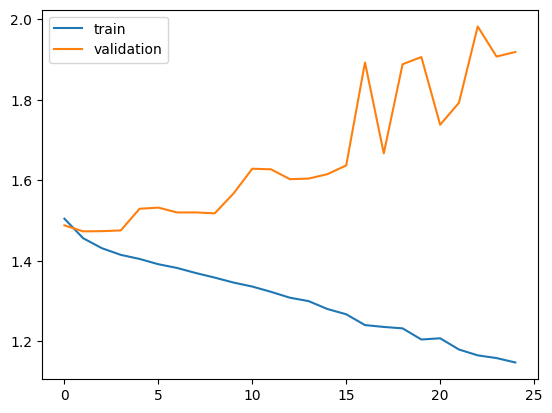

In [87]:
# Plot the loss
plt.plot(loss_train, label='train')
plt.plot(loss_validation, label='validation')
plt.legend()
plt.show()


# Create predictions

In [88]:
# Create a function that takes the model, data loader and device and returns the predictions
def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device)

            outputs = model(inputs)
            outputs = outputs.argmax(dim=-1).cpu().numpy() #Take the class with the highest probability
            predictions.append(outputs)
            targets.append(labels.numpy())

    return np.concatenate(predictions), np.concatenate(targets)

In [89]:
#Debug test
x, y = next(iter(train_loader))
output = model(x.to(device))

In [90]:
output.shape

torch.Size([1024, 128, 5])

In [91]:
y[2]

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1])

In [107]:
# Create a diffusion matrix of the train and validation data

yPredTrain, yTrainNp = get_predictions(model, train_loader, device)
yPredValidation, yValidationNp = get_predictions(model, validation_loader, device)

In [108]:
yPredTrain[17]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], dtype=int64)

In [109]:
yTrainNp[17]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int64)

In [110]:
#Create a vector for classification report
yTrainNp = yTrainNp.reshape(-1)
yPredTrain = yPredTrain.reshape(-1)

#Remove the padding classes
mask = yTrainNp != -1
yTrainNp = yTrainNp[mask]
yPredTrain = yPredTrain[mask]

#Create a vector for classification report
yValidationNp = yValidationNp.reshape(-1)
yPredValidation = yPredValidation.reshape(-1)

#Remove the padding classes
mask = yValidationNp != -1
yValidationNp = yValidationNp[mask]
yPredValidation = yPredValidation[mask]


In [111]:
from sklearn.metrics import classification_report

#Print the classification report
print('Training data:')
print(classification_report(yTrainNp, yPredTrain))

print('Validation data:')
print(classification_report(yValidationNp, yPredValidation))


Training data:
              precision    recall  f1-score   support

           0       0.99      0.68      0.81    890727
           1       0.03      0.46      0.05     12503
           2       0.03      0.19      0.05      6179
           3       0.01      0.03      0.01      3200
           4       0.03      0.34      0.05      3858

    accuracy                           0.67    916467
   macro avg       0.22      0.34      0.19    916467
weighted avg       0.97      0.67      0.78    916467

Validation data:
              precision    recall  f1-score   support

           0       1.00      0.52      0.68    194050
           1       0.01      0.32      0.01       830
           2       0.00      0.45      0.01       392
           3       0.00      0.02      0.00       159
           4       0.01      0.24      0.01       173

    accuracy                           0.52    195604
   macro avg       0.20      0.31      0.14    195604
weighted avg       0.99      0.52      0.68  

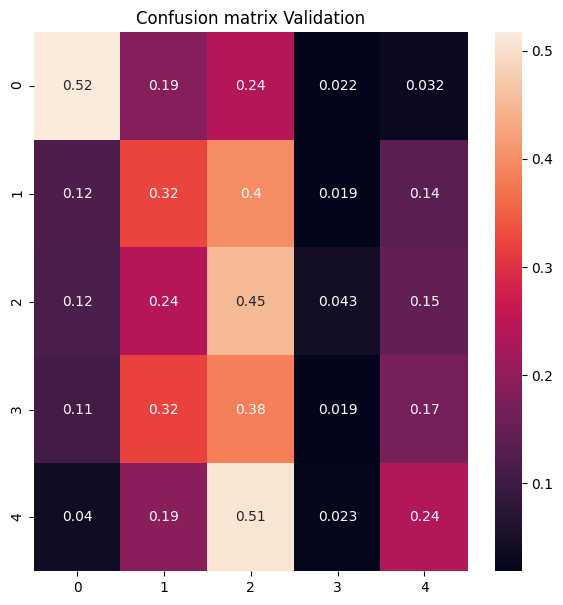

In [112]:
#Import confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yValidationNp, yPredValidation, normalize='true')
plt.figure(figsize = (7,7))
#add labels
plt.title('Confusion matrix Validation')
plt.xlabel('Predicted')
plt.ylabel('True')
#plot the confusion matrix
ax = sns.heatmap(cm, annot=True)

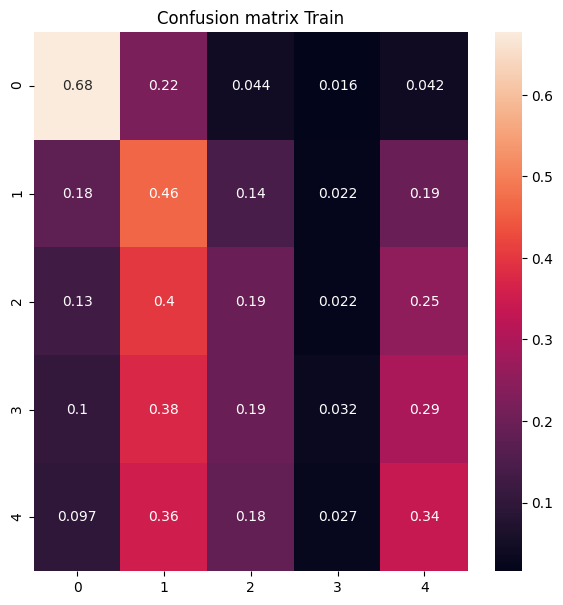

In [113]:
cm = confusion_matrix(yTrainNp, yPredTrain, normalize='true')
plt.figure(figsize = (7,7))
#add labels
plt.title('Confusion matrix Train')
plt.xlabel('Predicted')
plt.ylabel('True')
#plot the confusion matrix
ax = sns.heatmap(cm, annot=True)

In [102]:
checkpoint_path = 'model5.pth'

In [103]:
#Clone the latest model
import copy
model_latest = copy.deepcopy(model)

In [104]:
#Load the best model
model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

In [105]:
model.to(device)

XLSTM(
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (categorical_embeddings): ModuleList(
    (0): Embedding(3, 5)
    (1): Embedding(29, 5)
    (2): Embedding(21, 5)
    (3): Embedding(4, 5)
    (4): Embedding(2, 5)
    (5): Embedding(5, 5)
    (6): Embedding(17, 5)
    (7): Embedding(9, 5)
  )
  (input_layer): Linear(in_features=146, out_features=512, bias=True)
  (layer_norm1): LayerNorm((146,), eps=1e-05, elementwise_affine=True)
  (layer_norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (input_batch_norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(512, 512, num_layers=3, batch_first=True, dropout=0.1)
  (output_layer): Linear(in_features=512, out_features=5, bias=True)
)

In [106]:
from torchinfo import summary
summary(model, (2, XTrain.shape[1], XTrain.shape[2]))

Layer (type:depth-idx)                   Output Shape              Param #
XLSTM                                    [2, 128, 5]               --
├─ModuleList: 1-1                        --                        --
│    └─Embedding: 2-1                    [2, 128, 5]               15
│    └─Embedding: 2-2                    [2, 128, 5]               145
│    └─Embedding: 2-3                    [2, 128, 5]               105
│    └─Embedding: 2-4                    [2, 128, 5]               20
│    └─Embedding: 2-5                    [2, 128, 5]               10
│    └─Embedding: 2-6                    [2, 128, 5]               25
│    └─Embedding: 2-7                    [2, 128, 5]               85
│    └─Embedding: 2-8                    [2, 128, 5]               45
├─LayerNorm: 1-2                         [2, 128, 146]             292
├─Dropout: 1-3                           [2, 128, 146]             --
├─Linear: 1-4                            [2, 128, 512]             75,264
├─BatchN